In [33]:
# import tensorflow_datasets as tfds
import pickle
import re
import string
from multiprocessing import Pool

import contractions
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tqdm
from keras.layers import (  # type: ignore
    LSTM,
    Dense,
    Dropout,
    Embedding,
    TextVectorization,
)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pandas import DataFrame, Series
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from spellchecker import SpellChecker
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()
tf.random.set_seed(17)
# tqdm.pandas()

About Sentiment140

This is the sentiment140 dataset.

It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .

It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet ( 2087)
3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted (robotickilldozr)
6. text: the text of the tweet (Lyx is cool)

Cargar datos desde los datasets de tensorflow

In [34]:
# df = tfds.load("sentiment140", data_dir="./input")

In [35]:
columns = ["target", "id", "date", "flag", "user", "text"]
df = pd.read_csv("./input/sentiment140.csv", encoding="ISO-8859-1", names=columns)

In [36]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Eliminacion de las columnas que no son necesarias

In [37]:
df.drop(["id", "date", "flag", "user"], axis="columns", inplace=True)
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Como vemos no hay valores faltantes, pero si hay algunas filas duplicadas

In [38]:
def summary(df: DataFrame):
    print("Shape: ", df.shape)
    print("Duplicate rows: ", df.duplicated().sum())
    return pd.DataFrame(
        index=df.columns,
        data={
            "Unique": df.nunique().values,
            "Missing": df.isnull().sum().values,
            "Type": df.dtypes,
        },
    )

In [39]:
summary(df)

Shape:  (1600000, 2)
Duplicate rows:  16309


,Unique,Missing,Type
target,2,0,int64
text,1581466,0,object


Eliminacion de filas duplicadas

In [40]:
df.drop_duplicates(inplace=True)

In [41]:
for i in range(100):
    print(df["text"][i])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
my whole body feels itchy and like its on fire 
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
@Kwesidei not the whole crew 
Need a hug 
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
@Tatiana_K nope they didn't have it 
@twittera que me muera ? 
spring break in plain city... it's snowing 
I just re-pierced my ears 
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
@octolinz16 It it counts, idk why I did either. you never talk to me anymore 
@smarrison i would've been the first, but i didn't have a gun.    not rea

Inicializacion de variables a usar en la limpieza de datos

In [42]:
spell = SpellChecker()
wln = WordNetLemmatizer()
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/jared/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jared/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
def correct_spellings(text: str) -> str:
    words = text.split()
    misspelled = spell.unknown(words)
    for i in range(len(words)):
        if words[i] in misspelled:
            word = spell.correction(words[i])
            if word:
                words[i] = word  # type: ignore
    return " ".join(words)

In [44]:
correct_spellings("corect is you runing")

'correct is you running'

In [45]:
def delete_stopwords(text: str):
    stop_words = stopwords.words("english")
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

In [46]:
delete_stopwords(
    "i would have been the first but i did not have a gun not really though zap spders jus a doucheclown"
)

'would first gun really though zap spders jus doucheclown'

In [47]:
def lemmatizer(text: str):
    words = [wln.lemmatize(word, pos="v") for word in text.split()]
    return " ".join(words)

In [48]:
lemmatizer(
    "is upset that he can't update his Facebook by texting it and might cry as a result  School today also. Blah!"
)

"be upset that he can't update his Facebook by texting it and might cry as a result School today also. Blah!"

In [49]:
def clean_text(text: str):
    if not text == "":
        text = text.lower()  # Convertir minusculas todo el texto
        text = re.sub(
            r"@[\S]+", "", text
        )  # Eliminar los nombres de usuarios con @ mencionados
        text = re.sub(
            r"((www\.[\S]+)|([https]+://[\S]+))", "", text
        )  # Eliminar las urls mencionadas
        text = re.sub(
            r"^\s+|\s+$|\s+(?=\s)", "", text
        )  # Eliminar espacios en blanco extras
        text = contractions.fix(text)  # type: ignore # Expandir las contracciones

        text = re.sub(
            "[%s]" % re.escape(string.punctuation), "", text
        )  # Eliminar signos de puntuacion
        # text = re.sub(r"\w*\d\w*", "", text)  # Eliminar numeros y palabras con numeros
        text = re.sub(r"[^A-Za-z\s]*", "", text)
        # text = correct_spellings(text)  # Corregir ortografia de palabras
        # text = delete_stopwords(text)  # Eliminar palabas comunes
        # text = lemmatizer(text)  # Convertir las palabras a su verbo base
    return text

In [50]:
def process(data_part):
    text = data_part["text"].apply(clean_text)
    return text

In [51]:
partitions = np.array_split(df, 16)
pool = Pool(16)

/home/jared/micromamba/envs/delfin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [52]:
df_parts = pool.map(process, partitions)

In [53]:
clean_df = pd.concat(df_parts)

In [54]:
# PATH = "./input/glove.840B.300d.txt"


# embedding_dict = {}
# with open(PATH, "r", encoding="utf-8") as f:
#     for line in f:
#         values = line.split(" ")
#         word = values[0]
#         vectors = np.asarray(values[1:], "float32")
#         embedding_dict[word] = vectors

In [55]:
# with open("./input/glove.840B.300d.pkl", "wb") as f:
#     pickle.dump(embedding_dict, f)

In [57]:
with open("./input/glove.840B.300d.pkl", "rb") as f:
    embedding_dict = pickle.load(f)

In [59]:
import operator


def build_vocab(sentences: list) -> dict[str, float]:
    vocab = {}
    for text in sentences:
        for word in text.split():
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_coverage(
    vocab: dict[str, float], embeddings_index: dict[str, float]
) -> tuple[float, float, list[tuple]]:
    covered_words = {}
    oov = {}
    n_covered = n_oov = 0
    for word in vocab:
        try:
            covered_words[word] = embeddings_index[word]
            n_covered += vocab[word]
        except KeyError:
            oov[word] = vocab[word]
            n_oov += vocab[word]
    vocab_coverage = len(covered_words) / (len(vocab))
    text_coverage = n_covered / (n_covered + n_oov)
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return (vocab_coverage, text_coverage, sorted_oov)

In [60]:
vocab = build_vocab(list(clean_df))

In [ ]:
vocab

{'awww': 4980,
 'that': 172038,
 'is': 383256,
 'a': 376520,
 'bummer': 1442,
 'you': 364888,
 'shoulda': 348,
 'got': 69383,
 'david': 2267,
 'carr': 75,
 'of': 189222,
 'third': 814,
 'day': 84050,
 'to': 614198,
 'do': 136474,
 'it': 298478,
 'd': 6757,
 'upset': 2641,
 'he': 37483,
 'cannot': 64692,
 'update': 4243,
 'his': 15376,
 'facebook': 4196,
 'by': 30105,
 'texting': 727,
 'and': 297529,
 'might': 9620,
 'cry': 4395,
 'as': 40616,
 'result': 594,
 'school': 19597,
 'today': 64280,
 'also': 10252,
 'blah': 1471,
 'i': 984284,
 'dived': 3,
 'many': 8816,
 'times': 7664,
 'for': 214795,
 'the': 523491,
 'ball': 1272,
 'managed': 976,
 'save': 2190,
 'rest': 5203,
 'go': 72480,
 'out': 80092,
 'bounds': 19,
 'my': 311949,
 'whole': 5949,
 'body': 2467,
 'feels': 5120,
 'itchy': 440,
 'like': 77539,
 'its': 43693,
 'on': 166169,
 'fire': 1503,
 'no': 73713,
 'not': 281406,
 'behaving': 68,
 'at': 110561,
 'all': 82820,
 'am': 240021,
 'mad': 3793,
 'why': 27640,
 'here': 36719,


In [ ]:
len(vocab)

414983

In [61]:
vocab_coverage, text_coverage, oov = check_coverage(vocab, embedding_dict)

In [62]:
print("Found embeddings for {:.2%} of vocab".format(vocab_coverage))
print("Found embeddings for  {:.2%} of all text".format(text_coverage))

Found embeddings for 31.90% of vocab
Found embeddings for  97.93% of all text


In [ ]:
oov[:5]

[('quoti', 1604),
 ('gtlt', 813),
 ('quotyou', 628),
 ('youquot', 600),
 ('iranelection', 487)]

In [63]:
spell = SpellChecker(distance=1)

In [64]:
words_df = pd.DataFrame({"word": list(dict(oov).keys())})

In [65]:
def correct_spellings(word: str):
    correction = spell.correction(word)
    if correction:
        return correction
    return word

In [66]:
def task(data_part):
    text = data_part["word"].apply(correct_spellings)
    return text

In [67]:
partitions = np.array_split(words_df, 16)
pool = Pool(16)

/home/jared/micromamba/envs/delfin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [68]:
df_parts = pool.map(task, partitions)

In [69]:
words_df = pd.concat(df_parts)

In [70]:
new_words = {}
for i in range(len(oov)):
    if oov[i][0] != words_df.loc[i]:
        new_words[oov[i][0]] = words_df.loc[i]

In [71]:
len(new_words)

46186

In [72]:
def correct_word(text: str):
    words = text.split()
    for i in range(len(words)):
        try:
            words[i] = new_words[words[i]]
        except KeyError:
            pass
    return " ".join(words)

In [73]:
clean_df = clean_df.apply(correct_word)  # type: ignore

In [74]:
vocab = build_vocab(list(clean_df))

In [ ]:
len(vocab)

373089

In [75]:
vocab_coverage, text_coverage, oov = check_coverage(vocab, embedding_dict)
print("Found embeddings for {:.2%} of vocab".format(vocab_coverage))
print("Found embeddings for  {:.2%} of all text".format(text_coverage))

Found embeddings for 36.35% of vocab
Found embeddings for  98.30% of all text


In [32]:
type(vocab)

dict

In [29]:
# for word, _ in oov:
#     try:
#         vocab.pop(word)
#     except KeyError:
#         pass

In [76]:
max_tokens = len(vocab) - len(oov)

In [50]:
tf.keras.backend.clear_session()

In [32]:
# tokenizer = TextVectorization(standardize=None, vocabulary=list(vocab.keys()))
# # tokenizer.adapt(clean_df)
# vectorized_texts = tokenizer(clean_df)
# word_index = tokenizer.get_vocabulary()

In [77]:
tokenizer = TextVectorization(standardize=None, max_tokens=max_tokens)
tokenizer.adapt(clean_df)
vectorized_texts = tokenizer(clean_df)
word_index = tokenizer.get_vocabulary()

In [35]:
max_tokens

135620

In [78]:
embedding_dim = 300  # Dimensionalidad de los embeddings de GloVe
count = 0

embedding_matrix = np.zeros((len(word_index), embedding_dim))
for i, word in enumerate(word_index):
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        count += 1

print(f"Matriz de embeddings: {embedding_matrix.shape}")

Matriz de embeddings: (135620, 300)


In [79]:
count

90667

In [80]:
X = np.array(vectorized_texts)
y = df["target"].replace(4, 1).values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [82]:
max_tokens

135620

In [42]:
max_tokens = embedding_matrix.shape[0]

In [40]:
embedding_matrix.shape

(135622, 300)

In [52]:
# type: ignore
model = tf.keras.Sequential(
    [
        Embedding(max_tokens, embedding_dim, weights=[embedding_matrix]),
        Dropout(0.5),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation="sigmoid"),
    ],
)

In [53]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    40,686,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,686,600 (155.21 MB)

 Trainable params: 40,686,600 (155.21 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [55]:
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=32,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.7413 - loss: 0.5153 - val_accuracy: 0.8103 - val_loss: 0.4125
Epoch 2/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.8081 - loss: 0.4166 - val_accuracy: 0.8193 - val_loss: 0.3970
Epoch 3/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.8201 - loss: 0.3952 - val_accuracy: 0.8236 - val_loss: 0.3905
Epoch 4/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - accuracy: 0.8286 - loss: 0.3801 - val_accuracy: 0.8250 - val_loss: 0.3907
Epoch 5/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - accuracy: 0.8345 - loss: 0.3684 - val_accuracy: 0.8259 - val_loss: 0.3885
Epoch 6/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - accuracy: 0.8406 - loss: 0.3583 - val_accuracy: 0.8262 - val_loss: 0.3876
Epoch 7/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - accuracy: 0.8458 - loss: 0.3487 - val_accuracy: 0.8255 - val_loss: 0.3903
Epoch 8/32
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - accuracy: 0.8500 -

In [83]:
model = tf.keras.models.load_model("saved_model/lstm40Mparams.keras")

/home/jared/micromamba/envs/delfin/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [84]:
model.evaluate(X_test, y_test, batch_size=1024)

310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8242 - loss: 0.4047


[0.4053652286529541, 0.824877917766571]

In [85]:
y_pred = model.predict(X_test)

9899/9899 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step


In [86]:
y_pred = [0 if pred <= 0.49 else 1 for pred in y_pred]

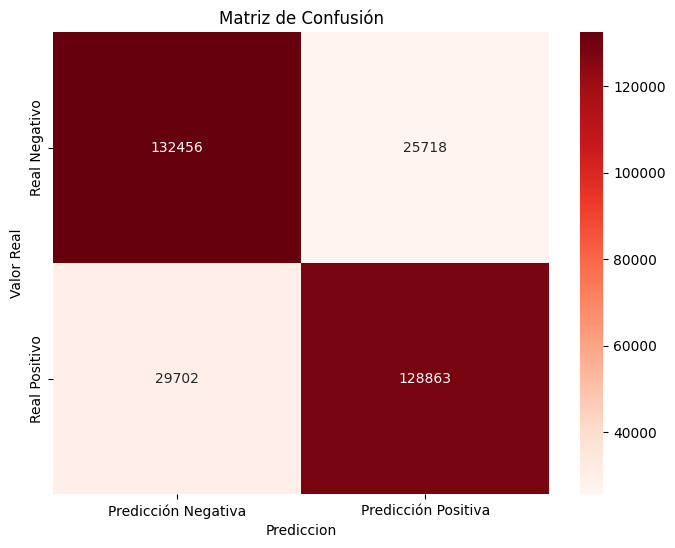

In [87]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Predicción Negativa", "Predicción Positiva"],
    yticklabels=["Real Negativo", "Real Positivo"],
)
plt.xlabel("Prediccion")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

In [88]:
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8250294406435582


In [89]:
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"recall (specificity): {specificity}")

              precision    recall  f1-score   support

           0       0.82      0.84      0.83    158174
           1       0.83      0.81      0.82    158565

    accuracy                           0.83    316739
   macro avg       0.83      0.83      0.83    316739
weighted avg       0.83      0.83      0.83    316739

recall (specificity): 0.8374069063183582


In [87]:
def predict(text: str):
    return "Negativo" if model.predict(tokenizer([text]))[0] <= 0.49 else "Positivo"

In [89]:
predict("i can not run")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Negativo'

In [90]:
predict("I hate the rain")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


'Negativo'

In [91]:
predict("I love the music")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Positivo'

In [95]:
predict("I like pizza")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'Positivo'

In [56]:
model.save("saved_model/lstm40Mparams2.keras")